In [1]:
from keras.layers import Input, Conv2D, BatchNormalization, GlobalAvgPool2D, ReLU, MaxPooling2D, AveragePooling2D, Concatenate, GlobalMaxPooling2D, Dropout, Dense, Lambda, Reshape, Activation, Multiply, Add
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pywt 
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

2025-04-11 14:09:32.433785: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, MaxPool2D
from keras.layers.core import Lambda
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model, Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
from keras.models import load_model
from keras.layers.core import Lambda
import os
from keras.layers import *
from sklearn.model_selection import KFold, StratifiedKFold
from keras.backend import int_shape
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Add, Activation, Lambda, Average
from keras import backend as K
from keras.activations import sigmoid
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
from tensorflow.python.ops.gen_math_ops import mul
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

  0%|          | 0/3419 [00:00<?, ?it/s]

100%|██████████| 186/186 [00:01<00:00, 137.58it/s]


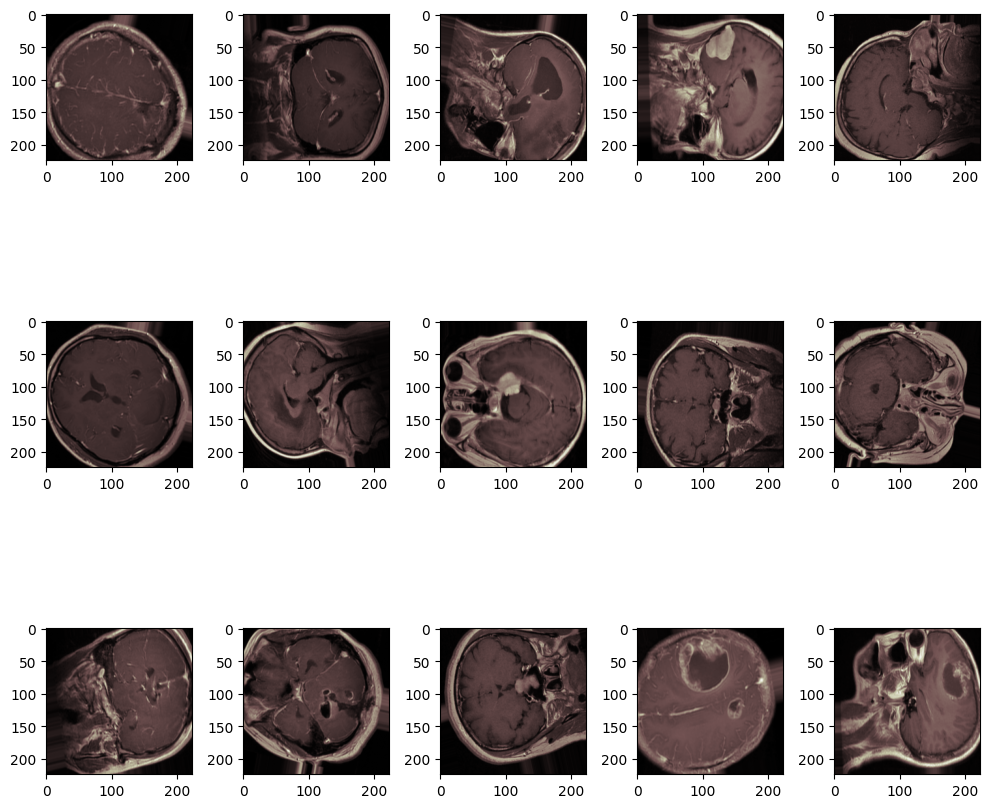

(614, 224, 224, 3)
(10534, 224, 224, 3)
(614, 3)
(10534, 3)


In [3]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 224
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [4]:
def swish(x, beta = 1):
    return(x * sigmoid(beta * x))
get_custom_objects().update({'swish': Activation(swish)})



In [5]:
def channel_shuffle(x, groups):  
    _, width, height, channels = x.get_shape().as_list()
    group_ch = channels // groups
 
    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x

In [6]:
def conv_module(x,k):
    a=Conv2D(k,(1,1),padding='same')(x)
    a=BatchNormalization()(a)
    a=Activation('swish')(a)

    y=Conv2D(k//2,(3,3),padding='same')(x)
    y=BatchNormalization()(y)
    y=Activation('swish')(y)
    y=Conv2D(k//2,(3,3),padding='same')(y)
    y=BatchNormalization()(y)
    y=Activation('swish')(y)

    z=Conv2D(k,(3,3),padding='same')(x)
    z=BatchNormalization()(z)
    z=Activation('swish')(z)
    c=tf.keras.layers.Concatenate()([y,z])

    d=DepthwiseConv2D(3,padding='same')(c)
    d=BatchNormalization()(d)
    d=Activation('swish')(d)
    x=tf.keras.layers.Concatenate()([d,c])
    x=tf.keras.layers.Concatenate()([x,a])
    x=Conv2D(k,(1,1),padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation('swish')(x)

    return x

In [7]:
def CSDA(inputs):
    shape=K.int_shape(inputs)
    x=MaxPooling2D(pool_size=(shape[1],shape[2])) (inputs)
    x=Conv2D(shape[3]//4,1, padding='same') (x)
    x=Activation('swish') (x)
    x=Conv2D(shape[3],1, padding='same') (x)
    x=Activation('sigmoid') (x)
    y=AveragePooling2D(pool_size=(shape[1],shape[2])) (inputs)
    y=Conv2D(shape[3]//4,1, padding='same') (y)
    y=Activation('swish') (x)
    y=Conv2D(shape[3],1, padding='same') (y)
    y=Activation('sigmoid') (y)
    z=tf.keras.layers.Average()([x,y])
    C_A=tf.math.multiply(z,inputs)
    
    a=Lambda(lambda x: K.max(x,axis=3,keepdims=True))  (inputs)
    a=Conv2D(shape[3] // shape[3],1, padding='same') (a)
    a=Activation('sigmoid') (a)
    b=Lambda(lambda x: K.mean(x,axis=3,keepdims=True))  (inputs)
    b=Conv2D(shape[3] // shape[3],1, padding='same') (b)
    b=Activation('sigmoid') (b)
    c=tf.keras.layers.Average()([a,b])
    S_A=tf.math.multiply(c,inputs)
    v=tf.keras.layers.Add()([C_A,S_A])
    d=channel_shuffle(inputs, 8)
    x=tf.keras.layers.Add()([v,d])
    return x

In [8]:
def load_model():
  input_shape = (224,224,3)
  inputs = Input(shape=(224,224,3))
  x=Conv2D(32,3, padding='same') (inputs)
  x=BatchNormalization()(x)
  x=Activation('swish')(x)
  x=MaxPooling2D()(x)
  x=conv_module(x,64)
  x=MaxPooling2D()(x)
  x=CSDA(x)
  x=conv_module(x,128)
  x=MaxPooling2D()(x)
  x=CSDA(x)
  x=conv_module(x,256)
  x=MaxPooling2D()(x)
  x=CSDA(x)
  x=Conv2D(256,3, padding='same') (x)
  x=BatchNormalization()(x)
  x=Activation('swish')(x)
  x=MaxPooling2D()(x)
  x=CSDA(x)
  x=GlobalAveragePooling2D()(x)
  x=Dense(3,activation='softmax')(x)
  model=Model(inputs, x)
  return model

In [27]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_81 (Conv2D)             (None, 224, 224, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_32 (BatchN  (None, 224, 224, 32  128        ['conv2d_81[0][0]']              
 ormalization)                  )                                                           

In [28]:
tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-CDAMNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])

Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.5995 - accuracy: 0.7479
Epoch 1: saving model to model-CDAMNet.h5
Epoch 1: 44.00 seconds
264/264 [==============================] - 44s 142ms/step - loss: 0.5995 - accuracy: 0.7479 - val_loss: 1.6363 - val_accuracy: 0.3359 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3266 - accuracy: 0.8751
Epoch 2: saving model to model-CDAMNet.h5
Epoch 2: 35.33 seconds
264/264 [==============================] - 35s 134ms/step - loss: 0.3267 - accuracy: 0.8750 - val_loss: 2.4796 - val_accuracy: 0.3899 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2102 - accuracy: 0.9230
Epoch 3: saving model to model-CDAMNet.h5
Epoch 3: 36.36 seconds
264/264 [==============================] - 36s 138ms/step - loss: 0.2102 - accuracy: 0.9230 - val_loss: 0.5343 - val_accuracy: 0.7989 - lr: 1.0000e-04
Epoch 4/50
263/264 [============================>.] - ETA: 0s - 

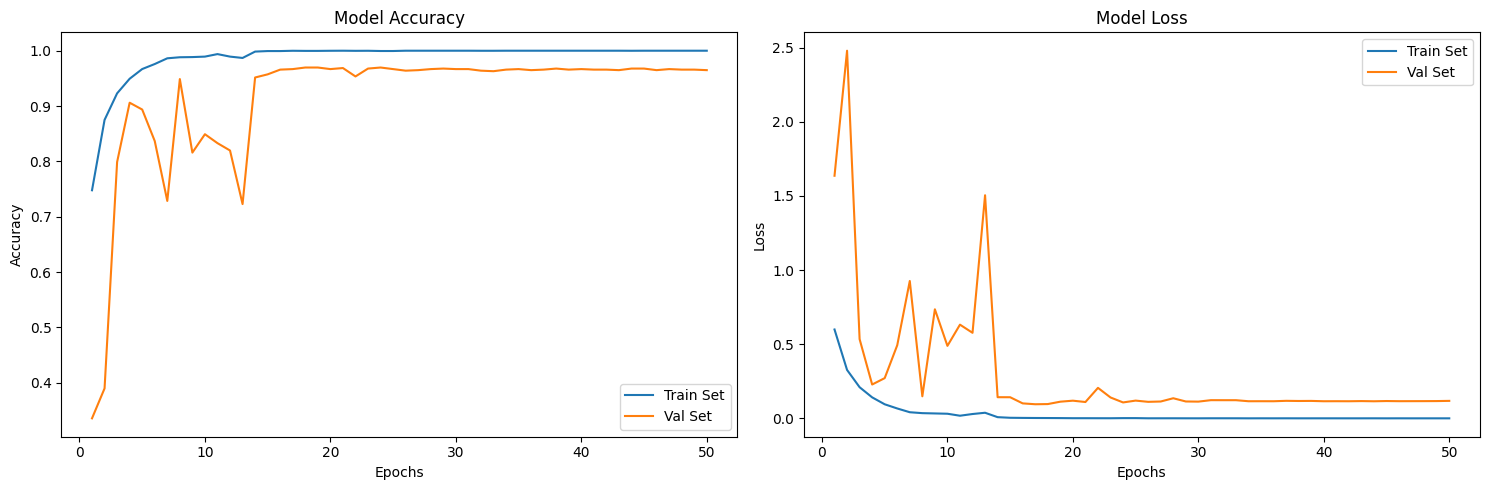

20/20 [==============================] - 1s 25ms/step - loss: 0.1284 - accuracy: 0.9593
Test Accuracy:  95.93
              precision    recall  f1-score   support

      glioma     0.9622    0.9790    0.9705       286
  meningioma     0.9412    0.9014    0.9209       142
   pituitary     0.9679    0.9731    0.9705       186

    accuracy                         0.9593       614
   macro avg     0.9571    0.9512    0.9540       614
weighted avg     0.9591    0.9593    0.9590       614



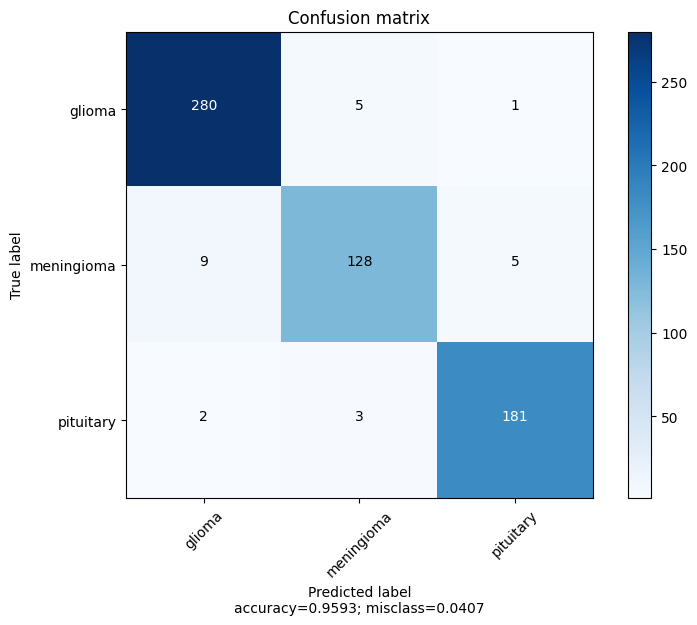

In [29]:
draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_122 (Conv2D)            (None, 224, 224, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_52 (BatchN  (None, 224, 224, 32  128        ['conv2d_122[0][0]']             
 ormalization)                  )                                                           

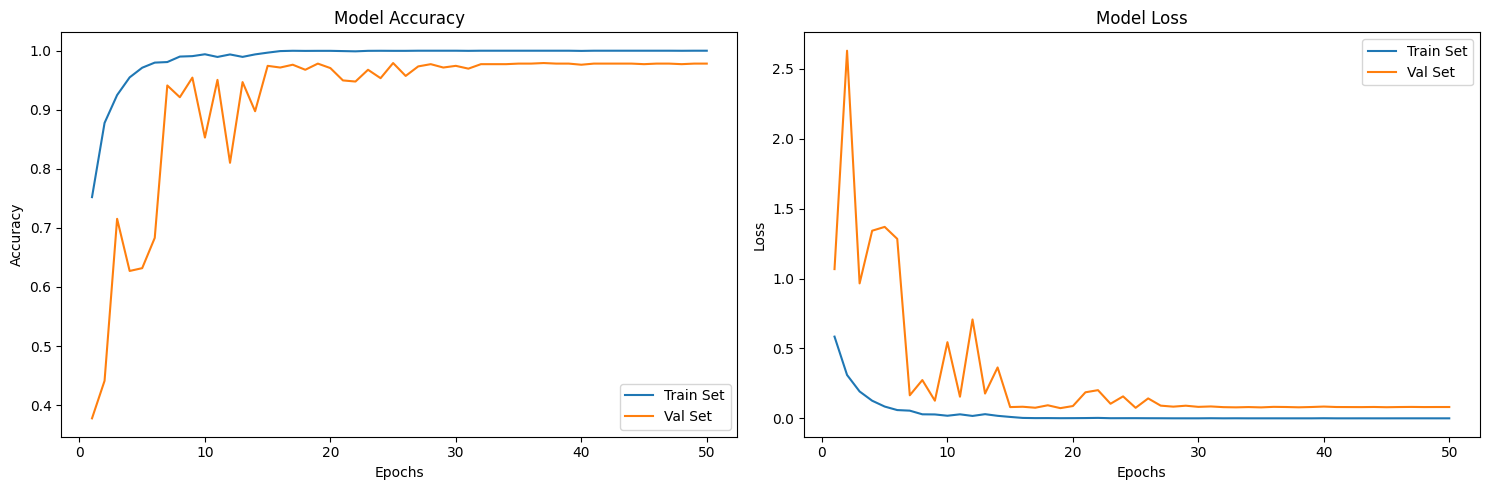

20/20 [==============================] - 1s 28ms/step - loss: 0.1450 - accuracy: 0.9544
Test Accuracy:  95.44
              precision    recall  f1-score   support

      glioma     0.9715    0.9545    0.9630       286
  meningioma     0.8926    0.9366    0.9141       142
   pituitary     0.9783    0.9677    0.9730       186

    accuracy                         0.9544       614
   macro avg     0.9475    0.9530    0.9500       614
weighted avg     0.9553    0.9544    0.9547       614



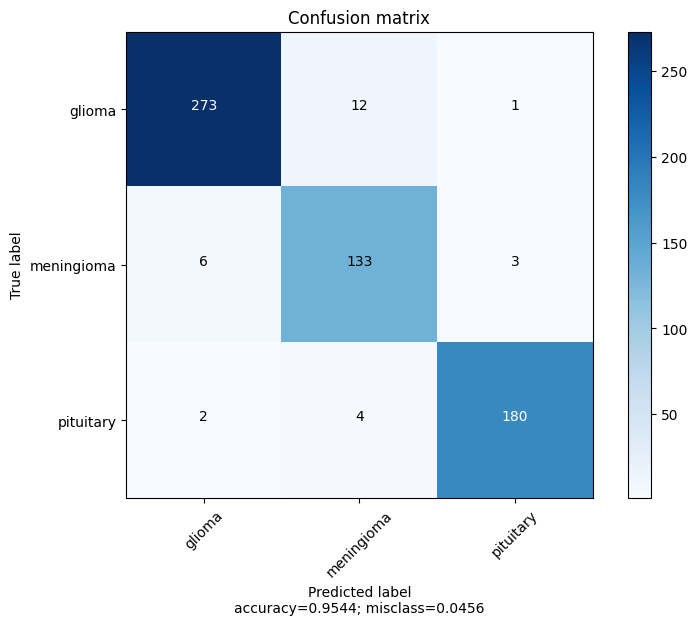

In [30]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-CDAMNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

2025-04-11 14:11:08.336732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-11 14:11:08.481509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22321 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:99:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

2025-04-11 14:11:26.975803: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2025-04-11 14:11:27.721772: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.5843 - accuracy: 0.7539
Epoch 1: saving model to model-CDAMNet.h5
Epoch 1: 46.68 seconds
264/264 [==============================] - 47s 154ms/step - loss: 0.5843 - accuracy: 0.7539 - val_loss: 1.3330 - val_accuracy: 0.3406 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.8718
Epoch 2: saving model to model-CDAMNet.h5
Epoch 2: 38.53 seconds
264/264 [==============================] - 39s 146ms/step - loss: 0.3365 - accuracy: 0.8718 - val_loss: 3.1804 - val_accuracy: 0.3577 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9174
Epoch 3: saving model to model-CDAMNet.h5
Epoch 3: 38.23 seconds
264/264 [==============================] - 38s 145ms/step - loss: 0.2209 - accuracy: 0.9174 - val_loss: 1.7470 - val_accuracy: 0.5313 - lr: 1.0000e-04
Epoch 4/50
264/264 [==============================] - ETA: 0s - loss: 0.146

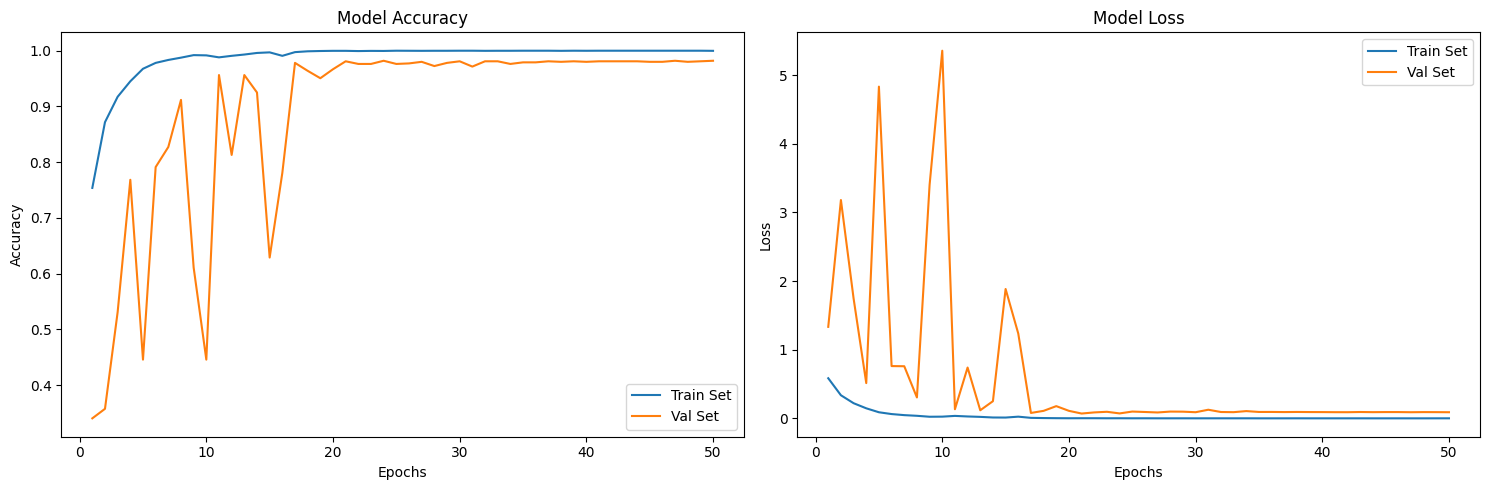

20/20 [==============================] - 1s 30ms/step - loss: 0.1751 - accuracy: 0.9609
Test Accuracy:  96.09
              precision    recall  f1-score   support

      glioma     0.9720    0.9720    0.9720       286
  meningioma     0.9155    0.9155    0.9155       142
   pituitary     0.9785    0.9785    0.9785       186

    accuracy                         0.9609       614
   macro avg     0.9553    0.9553    0.9553       614
weighted avg     0.9609    0.9609    0.9609       614



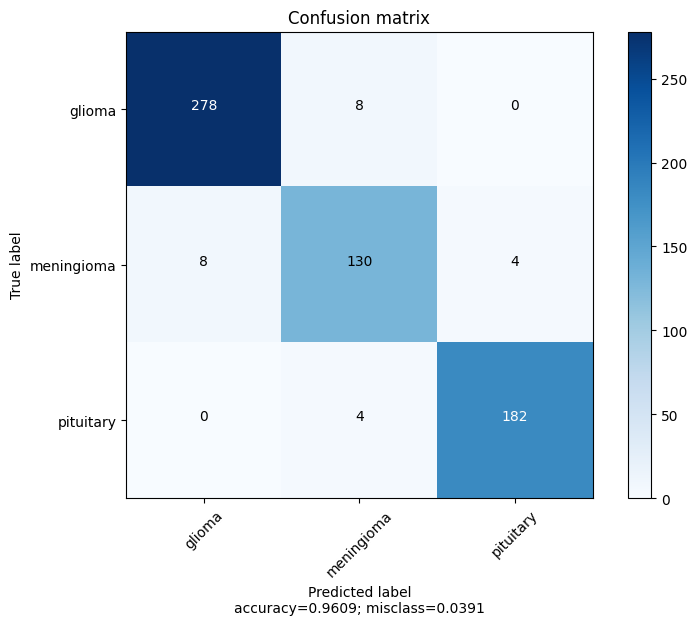

In [9]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-CDAMNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 224, 224, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 224, 224, 32  128        ['conv2d_41[0][0]']              
 ormalization)                  )                                                           

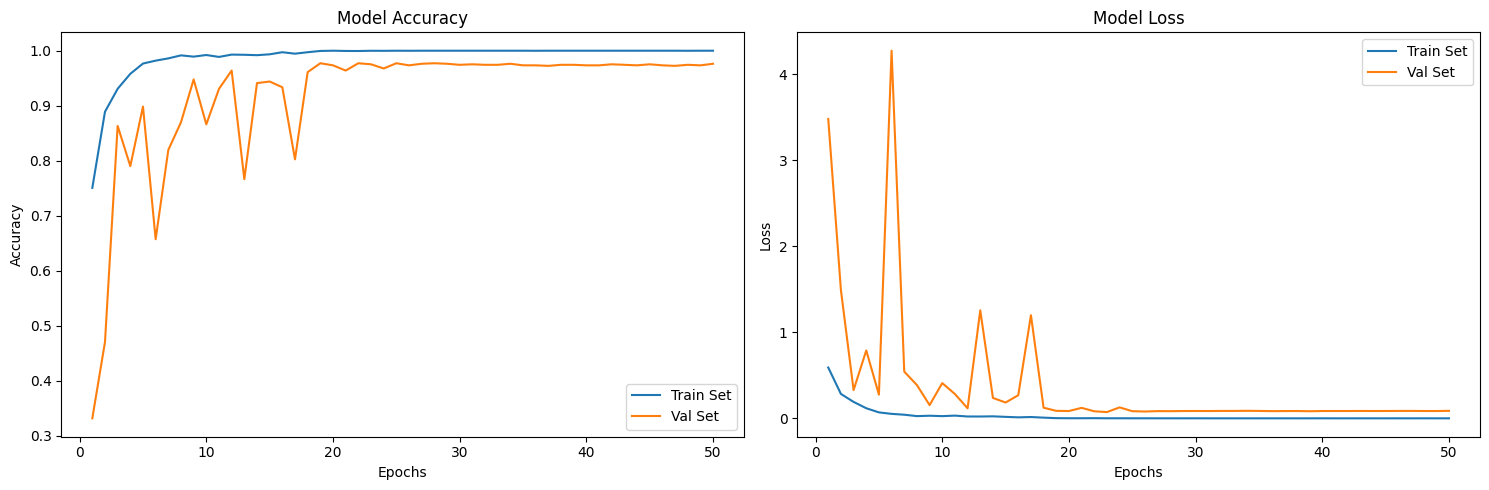

20/20 [==============================] - 1s 30ms/step - loss: 0.1826 - accuracy: 0.9495
Test Accuracy:  94.95
              precision    recall  f1-score   support

      glioma     0.9619    0.9720    0.9670       286
  meningioma     0.8889    0.9014    0.8951       142
   pituitary     0.9779    0.9516    0.9646       186

    accuracy                         0.9495       614
   macro avg     0.9429    0.9417    0.9422       614
weighted avg     0.9499    0.9495    0.9496       614



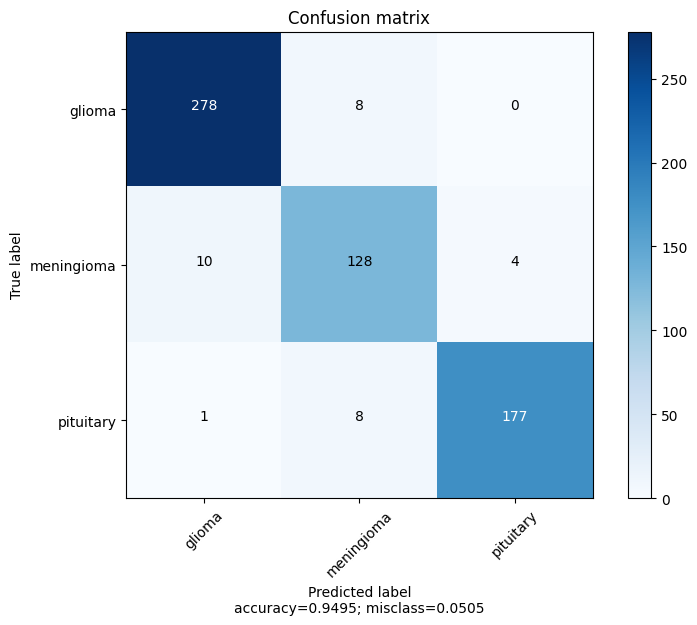

In [10]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-CDAMNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_82 (Conv2D)             (None, 224, 224, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_40 (BatchN  (None, 224, 224, 32  128        ['conv2d_82[0][0]']              
 ormalization)                  )                                                           

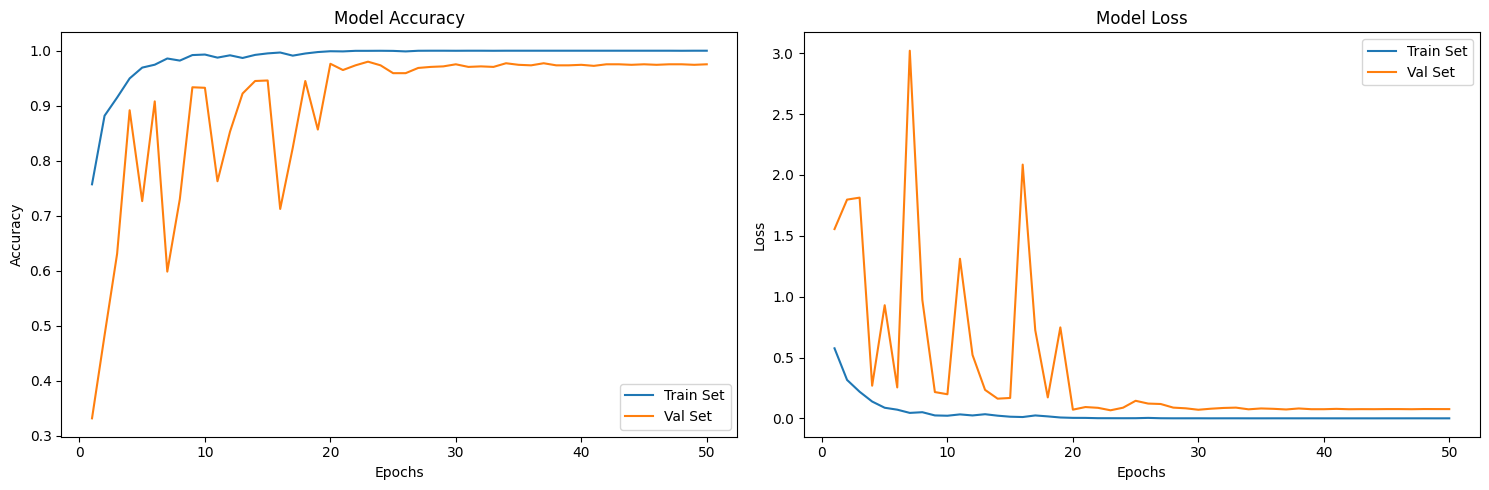

20/20 [==============================] - 1s 27ms/step - loss: 0.1371 - accuracy: 0.9642
Test Accuracy:  96.42
              precision    recall  f1-score   support

      glioma     0.9721    0.9755    0.9738       286
  meningioma     0.9236    0.9366    0.9301       142
   pituitary     0.9836    0.9677    0.9756       186

    accuracy                         0.9642       614
   macro avg     0.9598    0.9600    0.9598       614
weighted avg     0.9644    0.9642    0.9642       614



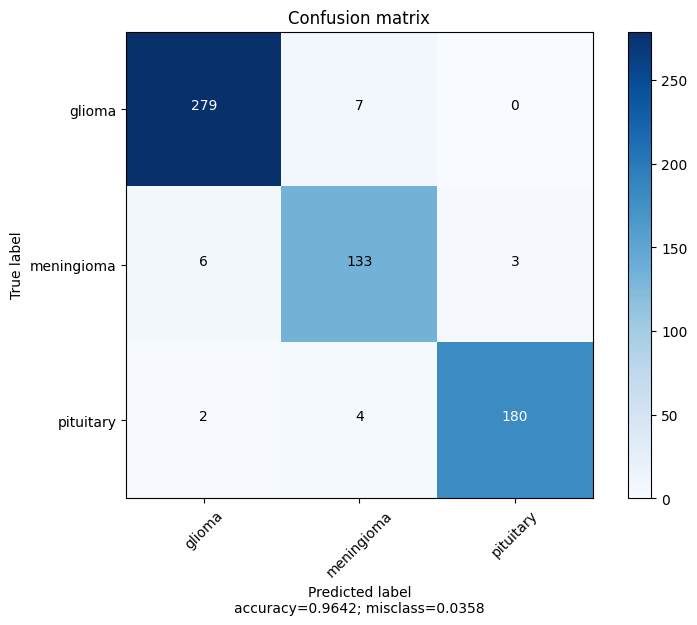

In [11]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-CDAMNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)